In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
from IPython.display import HTML, Video
from matplotlib.lines import Line2D

sys.path.append(str(Path("..").resolve()))
from src import *

# Denoising with Means and Medians

ℹ️ This notebook requires the samples of OABF dataset in the `dataset/sample/motion_corrected` folder generated with [1.1.1-Visualize_OABF_Dataset](../1-eda/1.1.1-Visualize_OABF_Dataset.ipynb).

Multi-frame averaging remains a baseline: simply averaging $N$ frames raises SNR by $\sqrt{N}$ [1] but is impractical for *live* imaging.

[1] SNR is defined as $\dfrac{\mu_{signal}}{\sigma_{noise}}$. Averaging $N$ frames decreases $\sigma_{noise}$ by $\sqrt{N}$, and thus SNR is increased by $\sqrt{N}$. Why? Because (sampling) variance of the mean of $N$ i.i.d. random variables is $\dfrac{1}{N}$​ times the variance of one.

In [5]:
astro_x_path = DATASETS["oabf_astro"].dir / "x.tiff"
astro_y_path = DATASETS["oabf_astro"].dir / "y.tiff"

vpm_x_path = DATASETS["oabf_vpm"].dir / "x.tiff"
vpm_y_path = DATASETS["oabf_vpm"].dir / "y.tiff"

resonant_neuro_x_path = DATASETS["oabf_resonant_neuro"].dir / "x.tiff"

In [6]:
# 5s
astro_x, astro_y = Recording(astro_x_path), Recording(astro_y_path)
vpm_x, vpm_y = Recording(vpm_x_path), Recording(vpm_y_path)
resonant_neuro_x = Recording(resonant_neuro_x_path)

## 1. Generate means and medians for different sliding window sizes

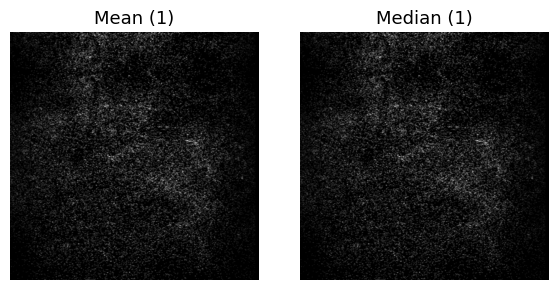

PSNR with baseline = 27.48dB 27.48dB
SSIM with baseline = 0.43 0.43


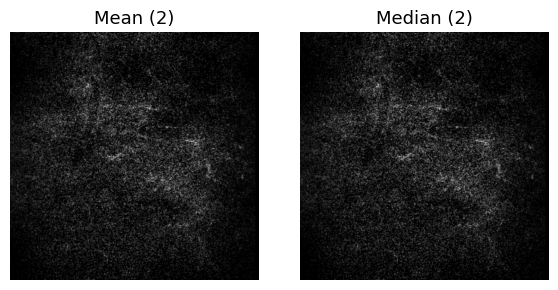

PSNR with baseline = 30.78dB 30.78dB
SSIM with baseline = 0.59 0.59


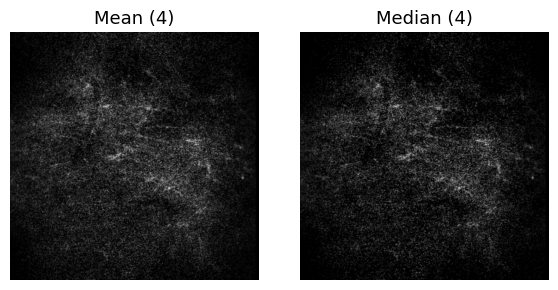

PSNR with baseline = 33.70dB 32.65dB
SSIM with baseline = 0.73 0.67


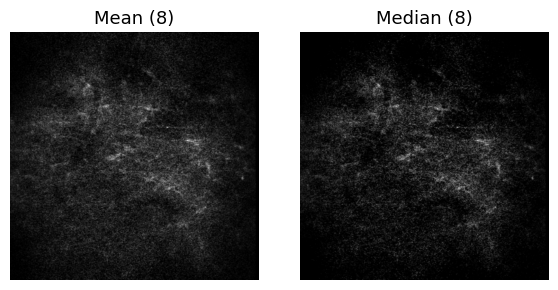

PSNR with baseline = 36.46dB 33.58dB
SSIM with baseline = 0.83 0.68


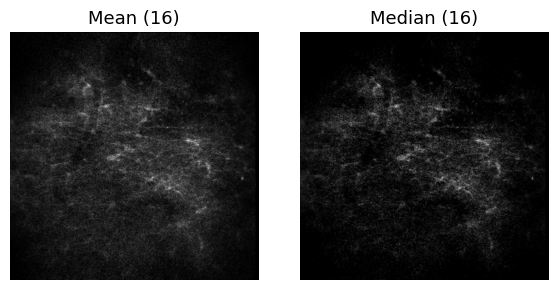

PSNR with baseline = 38.59dB 33.50dB
SSIM with baseline = 0.89 0.65


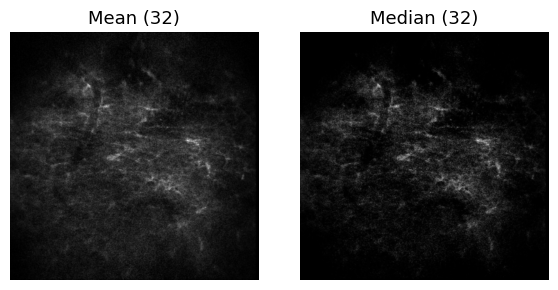

PSNR with baseline = 41.12dB 33.54dB
SSIM with baseline = 0.94 0.64


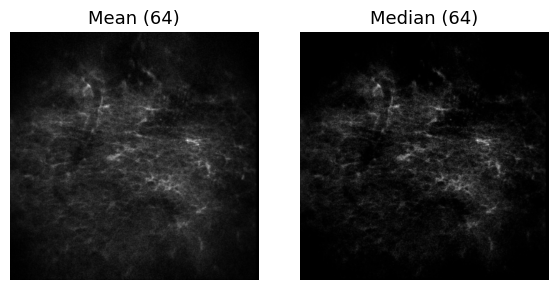

PSNR with baseline = 43.40dB 33.86dB
SSIM with baseline = 0.97 0.66


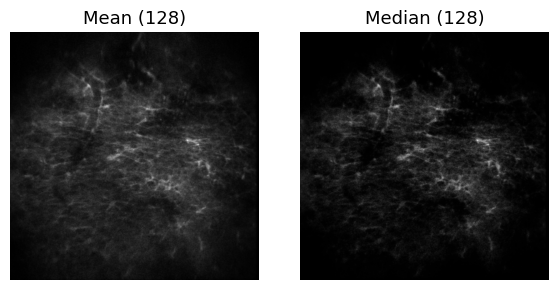

PSNR with baseline = 46.73dB 34.32dB
SSIM with baseline = 0.99 0.68


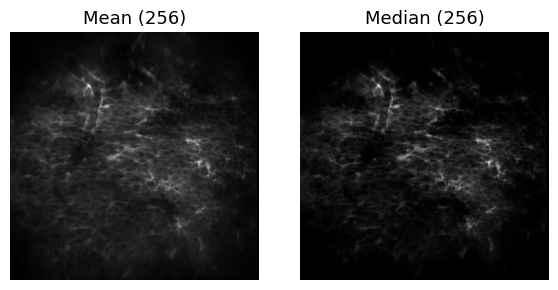

PSNR with baseline = 51.19dB 35.20dB
SSIM with baseline = 1.00 0.70


In [ ]:
metrics = pd.DataFrame(columns=["Mean PSNR", "Median PSNR", "Mean SSIM", "Median SSIM"])
metrics.index.name = "Window size"
target = np.mean(astro_x, axis=0)
for i in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    mean, median = (_(astro_x[:i], axis=0) for _ in [np.mean, np.median])
    imshow({f"Mean ({i})": mean, f"Median ({i})": median}, cmap="gray", size=3)
    psnr_mean, psnr_median = (peak_signal_noise_ratio(target, _, data_range=1) for _ in [mean, median])
    ssim_mean, ssim_median = (structural_similarity(target, _, data_range=1) for _ in [mean, median])
    cprint("PSNR with baseline =", f"green:{psnr_mean:.2f}dB", f"blue:{psnr_median:.2f}dB")
    cprint("SSIM with baseline =", f"green:{ssim_mean:.2f}", f"blue:{ssim_median:.2f}")
    metrics.loc[i] = [psnr_mean, psnr_median, ssim_mean, ssim_median]

The lower the PSNR, SSIM, the more degradated the original image is when compared to the averaged one. **Note that averaging/summing subsequent frames equals capturing  images with larger sensor exposure time** (pixel dwell time in 2PM). So basically it's like cheating: we blur out fast dynamics.

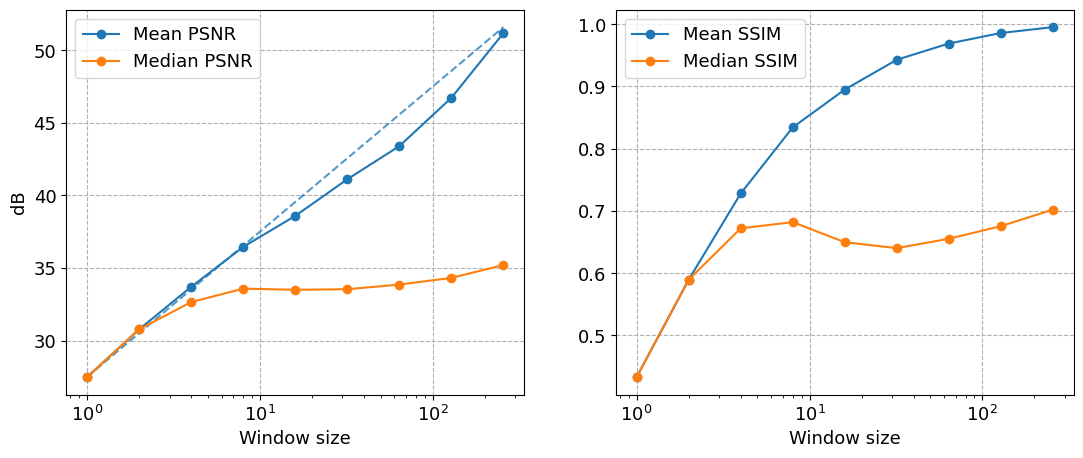

In [ ]:
_, axs = plt.subplots(1, 2,figsize=(13,5))
axs[0].plot([1, 256], [30-2.5, 54.1-2.5], linestyle='--', color='tab:blue', alpha=0.75)
metrics[["Mean PSNR", "Median PSNR"]].plot(marker="o", ax=axs[0])
axs[0].set_xscale("log")
axs[0].set_ylabel("dB")
metrics[["Mean SSIM", "Median SSIM"]].plot(marker="o", ax=axs[1])
axs[1].set_xscale("log")

As we expected, the Mean PSNR grows logarithmically with the window size. Doubling the window size increases the PSNR of about $10log_{10}​(2)\approx 3.01dB$. The empirical error is due to the Additive White Gaussian Noise (AWGN) hypothesis approximation.

The *Poisson* 2PM shot-noise can be approximated to:
- ***Gaussian***, when photon count is large enough,
- ***Additive***, when the variance is stabilized with Anscombe transform or the like.

## 2. Render averaged clean footage

In [5]:
aggregation=np.mean
window_size=64

In [ ]:
# 37s
for name, x in {"astro": astro_x, "vpm": vpm_x, "resonant_neuro": resonant_neuro_x}.items():
    cleaned = np.empty_like(x.np)
    length = x.frames
    for i in tqdm(range(length)):
        a = max(0, i - window_size // 2)
        b = min(length, i + window_size // 2)
        cleaned[i] = aggregation(x.np[a:b], axis=0)
    Recording(cleaned).render(f"{name}_averaged.mp4");

100%|██████████| 500/500 [00:06<00:00, 82.51it/s]


In [15]:
for name in ["astro", "vpm", "resonant_neuro"]:
    display(Video(f"{name}_averaged.mp4"))

The video is clear, but the dynamics are lost. To confirm this, play it side by side with the DeepCAD-cleaned version.

## 3. Trying Other Window Shapes

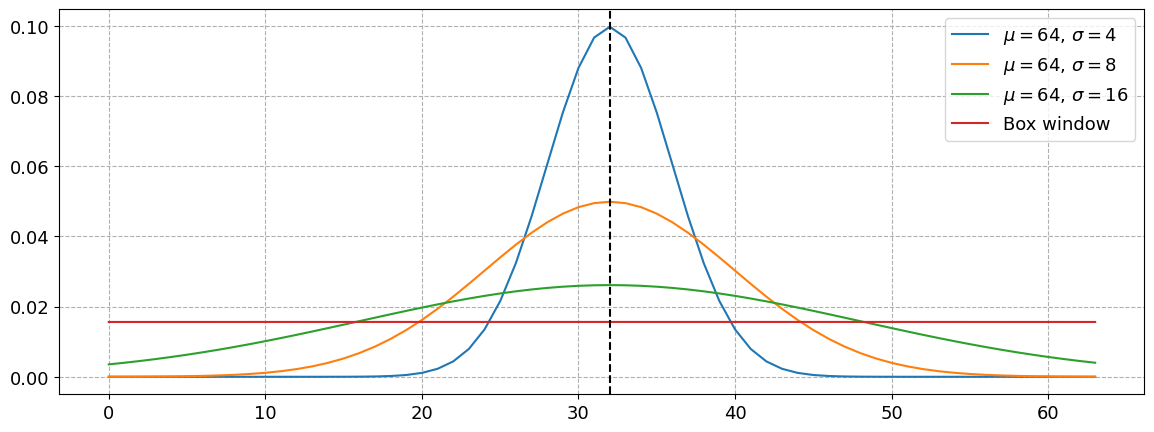

In [18]:
ax = pd.Series(gauss1D(64, sigma=4)).plot(figsize=(14, 5), label="$\mu=64$, $\sigma=4$")
pd.Series(gauss1D(64, sigma=8)).plot(ax=ax, label="$\mu=64$, $\sigma=8$")
pd.Series(gauss1D(64, sigma=16)).plot(ax=ax, label="$\mu=64$, $\sigma=16$")
pd.Series(gauss1D(64, sigma=999)).plot(ax=ax, label="Box window")
ax.legend()
ax.add_line(Line2D([32], list(ax.get_ylim()), linestyle="--", color="black"));

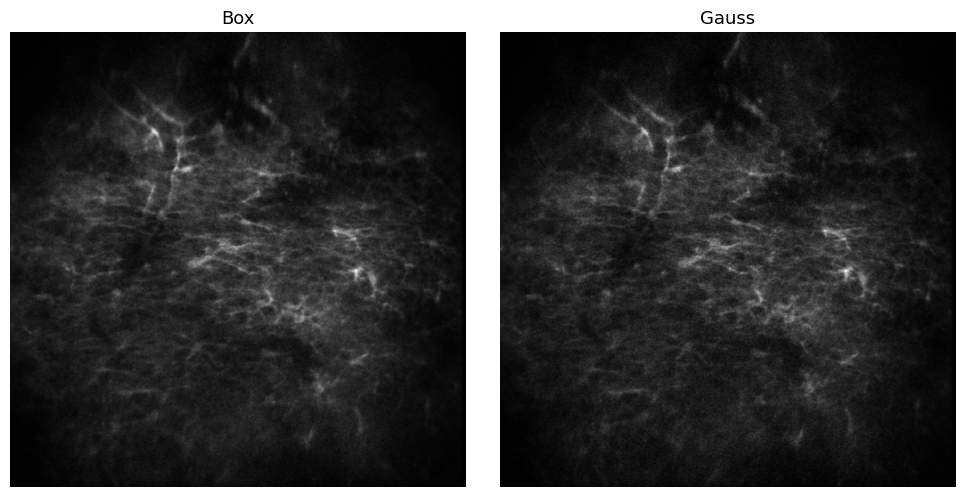

In [ ]:
imshow({"Box": astro_x.avg_frame(128, 128, "box"), "Gauss": astro_x.avg_frame(128, 128, "gauss")}, size=5)

In [ ]:
window_size=128
cleaned = np.empty_like(x.np)
for i in tqdm(range(x.frames)):
    cleaned[i] = astro_x.avg_frame(i, window_size, type="gauss")
Recording(cleaned).render(f"{name}_averaged_gauss.mp4")

100%|██████████| 300/300 [00:11<00:00, 25.44it/s]
